# Text II: Correspondence Analysis
#### Jan 3, 2021

## 1. Fetch data

In [1]:
import sqlalchemy
import configparser

# DB connection parameters
config = configparser.ConfigParser()
config.read('../db_config_final.ini')

host = config.get('database', 'host')
user = config.get('database', 'user')
passwd = config.get('database', 'passwd')


engine = sqlalchemy.create_engine('postgres://{0}:{1}@{2}:5432/{0}'.format(user, passwd, host, user))
meta = sqlalchemy.MetaData()
meta.reflect(bind=engine)

In [2]:
import pandas as pd

athletes_table = sqlalchemy.Table('athletes', meta, autoload=True)
q = athletes_table.select() # select query

dfa = pd.read_sql(q, engine)

In [3]:
posts_table = sqlalchemy.Table('posts', meta, autoload=True)
q = posts_table.select() # select query

dfp = pd.read_sql(q, engine)

### Merge and select relevant columns

In [4]:
df = dfa.merge(dfp, how='right', left_on='id', right_on='author')[['gender', 'performance_075xsigma', 'english_content', 'emojis']]

In [5]:
df.head()

gender performance_075xsigma  \
0      m                 under   
1      f                  over   
2      f                  over   
3      f                 under   
4      f                normal   

                                     english_content  \
0  Special World Cup race yesterday in Unfortunat...   
1  Thank you for this experience and grateful mom...   
2  I DID IT!!!! One last medal in my final race.....   
3  When I said I wanted to make memories in my fi...   
4  You dream about it, you work for it, but when ...   

                       emojis  
0             [😏, 💪🏼, 🙌🏼, 🙌🏼]  
1    [😍, ✨, 😊, 🙏, ☀, 👏, 💪, ⛷]  
2                [❤️, 🙏🏻, 🙌🏻]  
3    [🙏🏻, ❤️, 🤷🏼‍♀️, 🥇, 🥈, 🥉]  
4  [🤪, 🥳, 🎉, ☺️, ☺️, 🤗, 🤗, 🎉]

## 2. Text clean-up

- Lemmatise verbs and nouns; (note I'm not de-lemmatising)
- Find collocations;
- Tokenize (collocations stay together);
- Remove stopwords;
- Clean up emojis and add them to text.

### LEMMATISE

In [6]:
import spacy

model = spacy.load('en_core_web_md')

def spacy_lemmatise(x):
    doc = model(x)
    # only lemmatise verbs and nouns
    doc_lemma = ' '.join([ token.lemma_ if token.pos_ in ['VERB', 'NOUN'] else token.text for token in doc ])
    return(doc_lemma)

### COLLOCATIONS

In [7]:
# human choice (see previous notebook)
collocations = ['look forward', 'come true', 'world cup', 'world championship', 'giant slalom', 'world champion', 'final race', 'alpine combine']

In [8]:
import re

def glue_collocations(x):
    for c in collocations:
        x = re.sub(c, re.sub(' ', '_', c), x.lower())
    return(x)

### TOKENS

In [9]:
def words(x):
    x = re.sub('\u202a', '', x)
    x = re.sub('\u200d', '', x)
    x_split = re.split('[\s\.,!?()•“”:;’"‘‬,\'&\\\/]', x.lower())
    x_split = [x for x in x_split if not x.isdigit()]
    return([re.sub('_', ' ', x) for x in x_split if x not in ['', ' ', '-', '—']])

### STOPWORDS

Note how here we are adding a list of domain-specific stopwords.

In [10]:
stopwords = pd.read_csv("stopwords_final.txt", header=None)[0].to_list()

In [11]:
domain_stopwords = ['slalom', 'giant slalom', 'gs', 'giant-slalom', 'superg', 'super-g', 'sg', 'downhill', 'dh', 'alpine combined', 'alpine combine', 'ac', 'gepa', 'zoom', 'zoom-agence']

### EMOJIS

In [12]:
import emoji

# bad code
def emojis_normalised_towords(e):
    
    inwords = emoji.demojize(e) # from emoji to words

    inwords = re.sub('\u202a', '', inwords)
    inwords = re.sub('\u200d', '', inwords)

    inwords_2 = inwords
    
    # deal with skintones
    if 'skin_tone' in inwords:
        inwords_1 = re.sub(r'(?<=_)([a-z-]+)_skin_tone', '', inwords)
        inwords_2 = re.sub(r'_:', ':', inwords_1)

    # red hearts have weird behaviours. translate everything to yellow
    if inwords in [':red_heart:', ':heart_suit:', ':blue_heart:']:
        inwords_2 = ':yellow_heart:'
        
    if 'man' in inwords_2:
        inwords_2 = re.sub(':man', ':woman', inwords_2)
        
    if inwords_2 in [":person_shrugging:‍:female_sign:", ":person_shrugging::female_sign:"]:
        inwords_2 = ":woman_shrugging:"
        
    if inwords_2 in [":Slovakia:", ":Italy:", ":Norway:", ":Sweden:", ":Austria:", ":France:"]:
        inwords_2 = ''
    
    return(inwords_2)

### APPLY TO TEXT

In [13]:
df['english_content_lemmatised'] = df['english_content'].apply(spacy_lemmatise)
df['english_content_collocations'] = df['english_content_lemmatised'].apply(glue_collocations)
df['words'] = df['english_content_collocations'].apply(words)
df['meaning_words'] = df['words'].apply(lambda x: [xx for xx in x if xx not in stopwords])
df['meaning_words'] = df['meaning_words'].apply(lambda x: [xx for xx in x if not xx.isdigit() and xx.strip() not in domain_stopwords]) 
df['emojis_normalised_towords'] = df['emojis'].apply(lambda x: [emojis_normalised_towords(xx) for xx in x])

In [14]:
df['text'] = df['meaning_words'] + df['emojis_normalised_towords']

In [15]:
df = df[['gender', 'performance_075xsigma', 'text']]

In [16]:
df.head()

gender performance_075xsigma  \
0      m                 under   
1      f                  over   
2      f                  over   
3      f                 under   
4      f                normal   

                                                text  
0  [special, world cup, race, yesterday, unfortun...  
1  [thank, experience, grateful, moment, crowd, p...  
2  [one, last, medal, final race, ask, thank, eve...  
3  [want, memory, final race, mind, thankful, not...  
4  [dream, work, work, feeling, fight, tonight, e...

## 3. Correspondence analysis

### Create categories

In [17]:
def assign_category(x):
    if x['gender'] == 'f' and x['performance_075xsigma'] == 'under':
        return 1
    if x['gender'] == 'f' and x['performance_075xsigma'] == 'normal':
        return 2
    if x['gender'] == 'f' and x['performance_075xsigma'] == 'over':
        return 3
    if x['gender'] == 'm' and x['performance_075xsigma'] == 'under':
        return 4
    if x['gender'] == 'm' and x['performance_075xsigma'] == 'normal':
        return 5
    if x['gender'] == 'm' and x['performance_075xsigma'] == 'over':
        return 6
    
df['category'] = df.apply(assign_category, axis=1)

### Contingency matrix

In [18]:
df_categories = df.groupby(['category'])['text'].sum().reset_index(name='text')

In [19]:
df_categories.text.apply(len)

0    115
1    404
2    405
3    155
4    268
5    150
Name: text, dtype: int64

In [20]:
df_categories_expl = df_categories.explode('text')
df_categories_expl = df_categories_expl[df_categories_expl.text != '']
cm = pd.crosstab(df_categories_expl['text'], df_categories_expl['category'], margins=False)

In [21]:
cm = cm[cm.sum(axis=1) > 1] # remove words appearing only once in the whole corpus

In [22]:
cm.tail()

category   1  2  3  4  5  6
text                       
year       0  0  1  0  1  0
yes        0  0  0  0  2  1
yesterday  0  2  5  1  1  0
yet        0  1  1  0  0  0
åre        0  3  2  2  3  0

In [23]:
cm.sum(axis=0)

category
1     90
2    308
3    322
4    121
5    212
6    127
dtype: int64

### Run CA

In [24]:
import prince

In [25]:
ca = prince.CA(n_components=2)

In [26]:
ca = ca.fit(cm)

In [27]:
ca.row_coordinates(cm).tail()

0         1
year      -0.510124 -0.224661
yes        0.173699 -0.784244
yesterday -0.451582  0.057286
yet       -0.518017 -0.118136
åre        0.314889 -0.257374

In [28]:
ca.explained_inertia_

[0.23625377977235876, 0.21419550224969483]

### Select top terms

In [29]:
import statsmodels.api as sm

cm_sm = sm.stats.Table(cm)
residuals = cm_sm.resid_pearson

residuals.tail()

category          1         2         3         4         5         6
text                                                                 
year       0.043204 -0.403981  0.079754 -0.017552  0.378642 -0.039471
yes       -0.114714 -0.570937 -0.608936 -0.175787  1.233071  0.417158
yesterday -0.623315 -0.132722  1.771548 -0.248601 -0.546456 -0.714768
yet        0.043204  0.129420  0.079754 -0.017552 -0.224900 -0.039471
åre       -0.697701  0.375444 -0.338405  0.497322  0.809881 -0.791122

In [30]:
import numpy as np

top_words = []

for x in residuals.columns:
    res = residuals[x].nlargest(10).index.values
    top_words = np.append(top_words, res) 
   
residuals_top_words = residuals.loc[set(top_words)]

residuals_top_words['max_residual'] =  residuals_top_words.apply(lambda x: max(x), axis=1)
residuals_top_words['max_residual_category'] =  residuals_top_words.apply(lambda x: residuals_top_words.columns[x == max(x)][0], axis=1)
residuals_top_words.head()

category                  1         2         3         4         5         6  \
text                                                                            
:glowing_star:    -0.302366  2.152539 -0.816750 -0.364786 -0.582604 -0.387462   
round              1.841501 -0.570937 -0.143534 -0.175787 -0.386402 -0.197892   
hope              -0.302366 -0.776498 -0.816750  3.470224 -0.582604 -0.387462   
close             -0.406703  1.832763 -0.555792 -0.470309 -0.693627  0.008726   
:woman_shrugging:  3.320199 -0.504481 -0.935792 -0.470309 -0.252862 -0.493461   

category           max_residual  max_residual_category  
text                                                    
:glowing_star:         2.152539                      2  
round                  1.841501                      1  
hope                   3.470224                      4  
close                  1.832763                      2  
:woman_shrugging:      3.320199                      1

### Plot

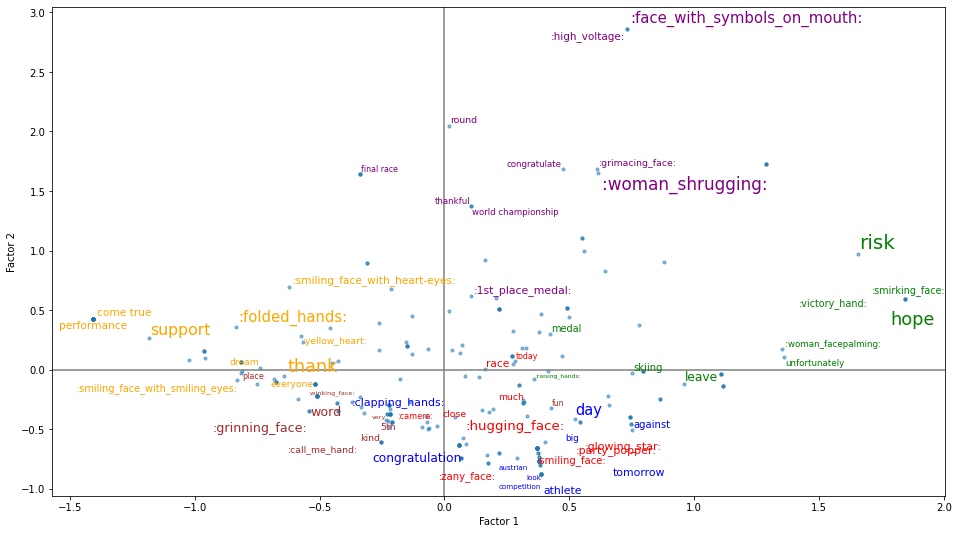

In [31]:
from matplotlib import pyplot as plt
from adjustText import adjust_text

points = ca.row_coordinates(cm).values
labels = ca.row_coordinates(cm).index.values
is_in_selection = [label in residuals_top_words.index.values for label in labels]

points_selection = points[is_in_selection]
labels_selection = labels[is_in_selection]

# .loc[labels_selection] to respect the order
fontsizes = np.interp(residuals_top_words.loc[labels_selection]['max_residual'], [residuals_top_words['max_residual'].min(), residuals_top_words['max_residual'].max()], [6,20])
color_dict = {1: 'purple', 2: 'red', 3: "orange", 4: "green", 5: 'blue', 6:'brown'}
fontcolor = residuals_top_words.loc[labels_selection]['max_residual_category'].map(color_dict)

plt.figure(figsize=(16,9))
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.scatter([i[0] for i in points], [i[1] for i in points], s=10, alpha=0.5)

texts = [plt.text(points_selection[i][0], points_selection[i][1], labels_selection[i], 
                  fontsize = fontsizes[i], color = fontcolor[i]) for i in range(len(labels_selection))]
adjust_text(texts)

plt.savefig("CA.svg")